In [15]:
import sklearn 
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import math
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    # if IS_COLAB:
    #     print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

In [3]:
# the goal is to teach model to predict just one value (the last one from a sequense)
def last_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[-1], y_pred[-1])

# split dataset to univariate samples
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(sequence.shape[0]):
        end_x_seq = i + n_steps
        # break if there is no enough data to add new X and y seqs
        if end_x_seq >= sequence.shape[0]:
            break
        # take and collet data sequences
        seq_X, seq_y = sequence[i:end_x_seq], sequence[end_x_seq] 
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
# data initialisation
def init_data(file_name):
    data = pd.read_csv('Data/'+file_name)
    data = data.set_index('Date')
    data.index = data.index.map(lambda x: str(x)[0:10])
    return data

# only close price is used
def clear_columns(pd):
    return pd.drop(["high", "low", "open", "volume",
                    "Adj Close"], axis=1)

In [5]:
# create and clear a dataframe
spx_1d_data = init_data('SPX_71_21.csv')
spx_1d_data = clear_columns(spx_1d_data)

In [6]:
# check the data
spx_1d_data
spx_1d_data.describe()
spx_1d_data.info()
spx_1d_data.shape
# check quantity of null and na value
spx_1d_data.isnull().sum()
spx_1d_data.isna().sum()
# display all nan rows if any
spx_1d_data[spx_1d_data.isna().any(axis=1)]
# check if there are inf values
np.isinf(spx_1d_data).any()
# check if there are 0s
(spx_1d_data == 0).sum(axis=1).any()
# (spx_1d_data == 0).astype(int).sum(axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 12842 entries, 1971-01-04 to 2021-11-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   12842 non-null  float64
dtypes: float64(1)
memory usage: 200.7+ KB


False

In [9]:
# create the dataset split it to train and val data
dataset = spx_1d_data.values
print(dataset[:5])
dataset.shape

[[91.15000153]
 [91.80000305]
 [92.34999847]
 [92.37999725]
 [92.19000244]]


(12842, 1)

In [10]:
# normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(dataset)
dataset = scaler.transform(dataset)
print(dataset[:5])

[[-0.98756209]
 [-0.98728205]
 [-0.9870451 ]
 [-0.98703218]
 [-0.98711403]]


In [12]:
# split data to train, val and test set
test_size = 21 # let's leave 21 sessions for testing
seq_length = 20
dataset_size = dataset.shape[0]
X_train, y_train = split_sequence(dataset[0: math.ceil(0.7 * dataset_size)], seq_length)
X_val, y_val = split_sequence(dataset[math.floor(0.7 * dataset_size):-test_size], seq_length)
X_test, y_test = split_sequence(dataset[-test_size:], seq_length)

In [14]:
# verify the sets
print(f'X_train shape is: {X_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'X_val shape is: {X_val.shape}')
print(f'y_val shape is: {y_val.shape}')
print(f'X_test shape is: {X_test.shape}')
print(f'y_test shape is: {y_test.shape}')

X_train shape is: (8970, 20, 1)
y_train shape is: (8970, 1)
X_val shape is: (3812, 20, 1)
y_val shape is: (3812, 1)
X_test shape is: (1, 20, 1)
y_test shape is: (1, 1)


In [21]:
# model's parameters
n_steps = X_train.shape[-2]
n_features = X_train.shape[-1]
epochs = 66

In [22]:
# RNN model 
# hiperparameters were found by kerastuner (will cover in other module)
model = keras.Sequential()
model.add(LSTM(units=200, activation="tanh", 
               activity_regularizer=keras.regularizers.l2(1e-4),
              input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=[last_step_mse])

history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/66
281/281 [==============================] - 3s 11ms/step - loss: 0.0043 - last_step_mse: 0.0051 - val_loss: 0.0019 - val_last_step_mse: 0.0025
Epoch 2/66
281/281 [==============================] - 3s 10ms/step - loss: 8.0962e-05 - last_step_mse: 3.6970e-05 - val_loss: 0.0017 - val_last_step_mse: 0.0023
Epoch 3/66
281/281 [==============================] - 3s 9ms/step - loss: 7.8462e-05 - last_step_mse: 2.3036e-05 - val_loss: 0.0017 - val_last_step_mse: 0.0021
Epoch 4/66
281/281 [==============================] - 3s 9ms/step - loss: 7.6390e-05 - last_step_mse: 3.2308e-05 - val_loss: 0.0015 - val_last_step_mse: 0.0019
Epoch 5/66
281/281 [==============================] - 3s 10ms/step - loss: 7.3355e-05 - last_step_mse: 2.8826e-05 - val_loss: 0.0013 - val_last_step_mse: 0.0017
Epoch 6/66
281/281 [==============================] - 3s 9ms/step - loss: 6.9843e-05 - last_step_mse: 2.4549e-05 - val_loss: 0.0011 - val_last_step_mse: 0.0014
Epoch 7/66
281/281 [=========================

Epoch 50/66
281/281 [==============================] - 2s 9ms/step - loss: 2.2857e-05 - last_step_mse: 1.6698e-05 - val_loss: 1.3579e-04 - val_last_step_mse: 1.3403e-04
Epoch 51/66
281/281 [==============================] - 3s 9ms/step - loss: 2.3461e-05 - last_step_mse: 1.2120e-05 - val_loss: 1.3981e-04 - val_last_step_mse: 1.4224e-04
Epoch 52/66
281/281 [==============================] - 2s 9ms/step - loss: 2.1177e-05 - last_step_mse: 1.3473e-05 - val_loss: 1.2920e-04 - val_last_step_mse: 1.2869e-04
Epoch 53/66
281/281 [==============================] - 2s 9ms/step - loss: 2.2188e-05 - last_step_mse: 1.1169e-05 - val_loss: 1.2985e-04 - val_last_step_mse: 1.2909e-04
Epoch 54/66
281/281 [==============================] - 3s 9ms/step - loss: 2.2519e-05 - last_step_mse: 1.5369e-05 - val_loss: 1.4356e-04 - val_last_step_mse: 1.4744e-04
Epoch 55/66
281/281 [==============================] - 3s 9ms/step - loss: 2.1629e-05 - last_step_mse: 1.4516e-05 - val_loss: 1.2469e-04 - val_last_step_ms

(0.0, 0.001)

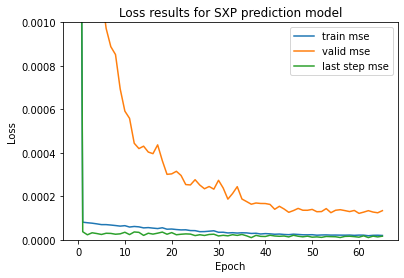

In [31]:
# plot the loss results
sns.lineplot(data=history.history['loss'], label='train mse')
sns.lineplot(data=history.history['val_loss'], label='valid mse')
sns.lineplot(data=history.history['last_step_mse'], label='last step mse')
plt.title('Loss results for SXP prediction model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.001)

In [48]:
# test the model
prediction = model.predict(X_test)
price = scaler.inverse_transform(prediction)[0][0]

In [57]:
f'The prediction price is {price:2.2f} while the true price is {scaler.inverse_transform(y_test)[0][0]}'

'The prediction price is 4608.45 while the true price is 4567.0'

In [61]:
f'The previous price is {spx_1d_data.close[-2]:2.2f}'

'The previous price is 4655.27'

In [62]:
# model has to be tested on bigger test set to consider it as a promising